### In this notebook we read in data needed for MARBL and generate 1D input files. 


In [6]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [7]:
%cd /glade/work/mlevy/cesm_inputdata/
IC_FILE               =  xr.open_dataset('ecosys_jan_IC_omip_MOM_tx0.66v1_c221027.nc') #Combination of WOA and other fields from POP includes BGC tracers
TS_IC_FILE            =  xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/mom/tx0.66v1/woa18_04_initial_conditions.nc',decode_times=False) #T and S fields

MARBL_FESEDFLUX_FILE  =  xr.open_dataset('fesedflux_total_reduce_oxic_tx0.66v1.c211109.nc') #From Matt's notebook based on POP output; only has nlon nlat, not actual  lon/lat
MARBL_FEVENTFLUX_FILE =  xr.open_dataset('feventflux_5gmol_tx0.66v1.c211109.nc') 

#Read in MARBL forcing from A-compset run:
MARBL_FORCING_FILE        =  xr.open_dataset('/glade/work/mlevy/codes/MOM6-examples/gen_forcing_on_tx066v1/MARBL_forcing.nc')

#This takes 2-3 minutes to read in:
%cd /glade/scratch/mlevy/archive/g.e23b09.TL319_t061.G1850MOMMARBL_JRA.006/ocn/hist
OTHER_FLUX_FILE = xr.open_mfdataset('g.e23b09.TL319_t061.G1850MOMMARBL_JRA.006.mom6.h_bgc_monthly_00*',decode_times=False) #Just ice fluxes


/glade/work/mlevy/cesm_inputdata
/glade/scratch/mlevy/archive/g.e23b09.TL319_t061.G1850MOMMARBL_JRA.006/ocn/hist


In [8]:
lat_array = IC_FILE['LAT']
lon_array = IC_FILE['LON']
#print(lat_array)

#We want to extract data at a certain lat/lon point. BATS location is 31.666667N, 64.166667W.
lat =  31.666667 
lon = -64.166667

# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(lat_array-lat)
abslon = np.abs(lon_array-lon)
c = np.maximum(abslat,abslon, )

([yloc],[xloc]) = np.where(c == np.min(c))

print(yloc,xloc)

313 334


In [9]:
#Finding indices for the Temperature and Salinity data (on a different grid)

ilon_TS = list(TS_IC_FILE.lon.values).index(TS_IC_FILE.sel(lon=lon, method='nearest').lon)
ilat_TS = list(TS_IC_FILE.lat.values).index(TS_IC_FILE.sel(lat=lat, method='nearest').lat)
print(' lon index=',ilon_TS,'\n','lat index=', ilat_TS)

 lon index= 463 
 lat index= 486


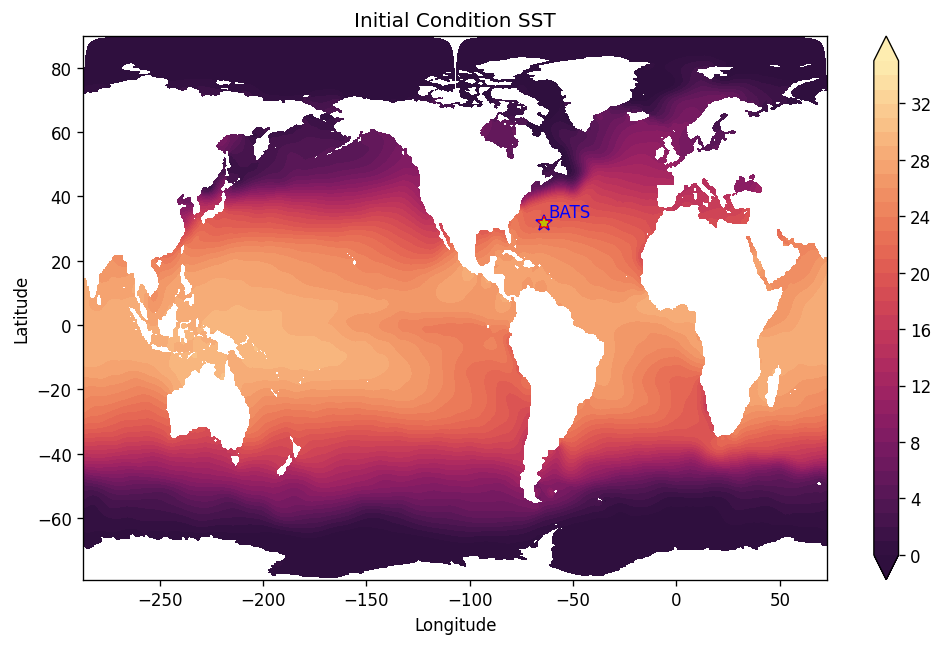

In [10]:
plt.figure(figsize=(10, 6),dpi=120)

plt.contourf(IC_FILE['LON'],IC_FILE['LAT'],IC_FILE['TEMP'][0,:],cmap=cmocean.cm.matter_r,vmin=0,vmax=35,levels=np.linspace(0,35,36),extend='both')
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Initial Condition SST')
plt.plot(lon_array[yloc,xloc],lat_array[yloc,xloc],'*b',markersize=10)
#plt.plot(IC_FILE.LON[yloc,xloc],IC_FILE.LAT[yloc,xloc],'*r',markersize=5)
plt.plot(TS_IC_FILE.lon[ilon_TS],TS_IC_FILE.lat[ilat_TS],'*r',markersize=8)
plt.plot(MARBL_FORCING_FILE.lon[yloc,xloc],MARBL_FORCING_FILE.lat[yloc,xloc],'*y',markersize=5)

plt.text(lon_array[yloc,xloc]+2,lat_array[yloc,xloc]+2,'BATS',color='b')
plt.show()

In [11]:
IC_FILE_COLUMN               = IC_FILE.isel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})
MARBL_FESEDFLUX_FILE_COLUMN  = MARBL_FESEDFLUX_FILE.isel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})
MARBL_FEVENTFLUX_FILE_COLUMN = MARBL_FEVENTFLUX_FILE.isel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})#.expand_dims(dim={'LAT':1,'LON':1},axis=[1,2])  #leaving braces around [xloc] and [yloc] preserves that dimension
OTHER_FLUX_FILE_COLUMN       = OTHER_FLUX_FILE.isel(time=range(0,12),xh=[xloc-1,xloc],yh=[yloc-1,yloc]).rename_dims({'xh':'lon','yh':'lat'})
FLUX_FILE_COLUMN = OTHER_FLUX_FILE_COLUMN[['SEAICE_BLACK_CARBON_FLUX_CPL','SEAICE_DUST_FLUX_CPL']].load()

TS_IC_FILE_COLUMN            = TS_IC_FILE.isel(lat=[ilat_TS-1,ilat_TS],lon=[ilon_TS-1,ilon_TS])

MARBL_FORCING_temp    = MARBL_FORCING_FILE.isel(nlat=[yloc-1,yloc], nlon=[xloc-1,xloc])
#MARBL_FORCING_temp    = MARBL_FORCING_FILE.isel(time = np.arange(0,365), nlat=[yloc-1,yloc], nlon=[xloc-1,xloc])


print(MARBL_FORCING_temp.lat[:,0])
print(MARBL_FORCING_temp.lon[0,:])

#Making some modifications to MARBL_FORCING_FILE_COLUMN:
ds = MARBL_FORCING_temp

ds = ds.rename_dims({'nlat': 'gridlat_t', 'nlon': 'gridlon_t'})
ds = ds.assign_coords({'gridlat_t': MARBL_FORCING_temp.lat[:,0], 'gridlon_t': MARBL_FORCING_temp.lon[0,:]})
ds.gridlat_t.attrs['units'] = 'degree_north'
ds.gridlat_t.attrs['cartesian_axis'] = 'Y'
ds.gridlon_t.attrs['units'] = 'degree_east'
ds.gridlon_t.attrs['cartesian_axis'] = 'X'

#ds.time.encoding['_FillValue'] = 10000000000. 
ds.time.attrs['units'] = "days since 1982-01-01 00:00:00"
ds.time.attrs['time_origin'] = "01-JAN-1982 00:00:00"
ds.time.attrs['calendar'] = 'NOLEAP'
ds.time.attrs['cartesian_axis'] = 'T'
ds.time.attrs['modulo'] = " "
ds.time.attrs['modulo_beg'] = "1982-01-01 00:00:00"
ds.time.attrs['modulo_end'] = "1987-01-01 00:00:00"


ds.gridlon_t.encoding['_FillValue'] = None
ds.gridlat_t.encoding['_FillValue'] = None

MARBL_FORCING_FILE_COLUMN = ds;



<xarray.DataArray 'lat' (nlat: 2)>
array([31.099484, 31.657515])
Coordinates:
    lat      (nlat) float64 ...
    lon      (nlat) float64 ...
Dimensions without coordinates: nlat
Attributes:
    units:    degrees_north
<xarray.DataArray 'lon' (nlon: 2)>
array([-64.682013, -64.015321])
Coordinates:
    lat      (nlon) float64 ...
    lon      (nlon) float64 ...
Dimensions without coordinates: nlon
Attributes:
    units:    degrees_east


In [12]:
FLUX_FILE_COLUMN

<xarray.Dataset>
Dimensions:                       (lat: 2, lon: 2, time: 12)
Coordinates:
    xh                            (lon) float64 -64.67 -64.0
    yh                            (lat) float64 31.18 31.75
  * time                          (time) float64 15.5 45.0 74.5 ... 319.0 349.5
Dimensions without coordinates: lat, lon
Data variables:
    SEAICE_BLACK_CARBON_FLUX_CPL  (time, lat, lon) float64 0.0 0.0 ... 0.0 0.0
    SEAICE_DUST_FLUX_CPL          (time, lat, lon) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    filename:          g.e23b09.TL319_t061.G1850MOMMARBL_JRA.006.mom6.h_bgc_m...
    title:             MOM6 diagnostic fields table for CESM case: g.e23b09.T...
    associated_files:  areacello: g.e23b09.TL319_t061.G1850MOMMARBL_JRA.006.m...
    grid_type:         regular
    grid_tile:         N/A

In [13]:
#Setting 4 points on the grid to be equal to the first point

field = list(IC_FILE_COLUMN.keys())
for field in field:
    IC_FILE_COLUMN[field][:,1,0]=IC_FILE_COLUMN[field][:,0,0]
    IC_FILE_COLUMN[field][:,0,1]=IC_FILE_COLUMN[field][:,0,0]
    IC_FILE_COLUMN[field][:,1,1]=IC_FILE_COLUMN[field][:,0,0]

field = ['FESEDFLUXIN','FESEDFLUXIN_oxic','FESEDFLUXIN_reduce']
for field in field:
    MARBL_FESEDFLUX_FILE_COLUMN[field][:,1,0]=MARBL_FESEDFLUX_FILE_COLUMN[field][:,0,0]
    MARBL_FESEDFLUX_FILE_COLUMN[field][:,0,1]=MARBL_FESEDFLUX_FILE_COLUMN[field][:,0,0]
    MARBL_FESEDFLUX_FILE_COLUMN[field][:,1,1]=MARBL_FESEDFLUX_FILE_COLUMN[field][:,0,0]
    
field = ['FESEDFLUXIN']
for field in field:
    MARBL_FEVENTFLUX_FILE_COLUMN[field][:,1,0]=MARBL_FEVENTFLUX_FILE_COLUMN[field][:,0,0]
    MARBL_FEVENTFLUX_FILE_COLUMN[field][:,0,1]=MARBL_FEVENTFLUX_FILE_COLUMN[field][:,0,0]
    MARBL_FEVENTFLUX_FILE_COLUMN[field][:,1,1]=MARBL_FEVENTFLUX_FILE_COLUMN[field][:,0,0]

field = list(FLUX_FILE_COLUMN.keys())
for field in field:
    FLUX_FILE_COLUMN[field][:,1,0]=FLUX_FILE_COLUMN[field][:,0,0]
    FLUX_FILE_COLUMN[field][:,0,1]=FLUX_FILE_COLUMN[field][:,0,0]
    FLUX_FILE_COLUMN[field][:,1,1]=FLUX_FILE_COLUMN[field][:,0,0]

field = list(TS_IC_FILE_COLUMN.keys())
for field in field:
    TS_IC_FILE_COLUMN[field][:,1,0]=TS_IC_FILE_COLUMN[field][:,0,0]
    TS_IC_FILE_COLUMN[field][:,0,1]=TS_IC_FILE_COLUMN[field][:,0,0]
    TS_IC_FILE_COLUMN[field][:,1,1]=TS_IC_FILE_COLUMN[field][:,0,0]

field = list(MARBL_FORCING_FILE_COLUMN.keys())
for field in field:
    MARBL_FORCING_FILE_COLUMN[field][:,1,0]=MARBL_FORCING_FILE_COLUMN[field][:,0,0]
    MARBL_FORCING_FILE_COLUMN[field][:,0,1]=MARBL_FORCING_FILE_COLUMN[field][:,0,0]
    MARBL_FORCING_FILE_COLUMN[field][:,1,1]=MARBL_FORCING_FILE_COLUMN[field][:,0,0]


In [14]:
# plt.figure(figsize=(10, 5),dpi=350)
# # plt.plot(FLUX_FILE_COLUMN.time,FLUX_FILE_COLUMN.ATM_BLACK_CARBON_FLUX_CPL[:,0,0],label='Black carbon flux [kg/m$^2$/s]',color='#233d4d')
# plt.plot(FLUX_FILE_COLUMN.time,FLUX_FILE_COLUMN.SEAICE_BLACK_CARBON_FLUX_CPL[:,0,0],label='Sea ice black carbon flux [kg/m$^2$/s]',color='#fe7f2d')
# # plt.plot(FLUX_FILE_COLUMN.time,FLUX_FILE_COLUMN.ATM_FINE_DUST_FLUX_CPL[:,0,0],label='Fine dust flux [kg/m$^2$/s]',color='#fcca46')
# #plt.plot(FLUX_FILE_COLUMN.time,FLUX_FILE_COLUMN.ATM_COARSE_DUST_FLUX_CPL[:,0,0],'*-',label='Coarse dust flux [kg/m$^2$/s]',color='#a1c181')
# #plt.plot(MARBL_FORCING_FILE_COLUMN.time,MARBL_FORCING_FILE_COLUMN.ATM_COARSE_DUST_FLUX[:,0,0],'*-',label='MARBL Coarse dust flux [kg/m$^2$/s]',color='r')

# plt.plot(FLUX_FILE_COLUMN.time,FLUX_FILE_COLUMN.SEAICE_DUST_FLUX_CPL[:,0,0],label='Sea ice dust flux [kg/m$^2$/s]',color='#619b8a')
# plt.legend()
# plt.ylabel('Flux')
# plt.xlabel('Day')
# plt.xlim([31,63]); #plt.ylim([0,10e-12])
# plt.grid()
# plt.title('Fluxes contributing to iron flux, 1 years of monthly averages')

In [15]:
#FLUX_FILE_COLUMN

##Modifications so that we use Kristen's 4p2z model:
print(IC_FILE_COLUMN)

IC_FILE_COLUMN['coccoC'] = IC_FILE_COLUMN['spC'] * 0.07
IC_FILE_COLUMN['coccoFe'] = IC_FILE_COLUMN['spFe'] * 0.07
IC_FILE_COLUMN['coccoP'] = IC_FILE_COLUMN['spP'] * 0.07
IC_FILE_COLUMN['coccoChl'] = IC_FILE_COLUMN['spChl'] * 0.07

# and then reduce the sp pools so biomass is conserved:
IC_FILE_COLUMN['spC'] = IC_FILE_COLUMN['spC'] * 0.93
IC_FILE_COLUMN['spFe'] = IC_FILE_COLUMN['spFe'] * 0.93
IC_FILE_COLUMN['spP'] = IC_FILE_COLUMN['spP'] * 0.93
IC_FILE_COLUMN['spChl'] = IC_FILE_COLUMN['spChl'] * 0.93

#For coccoCaCO3, just set that equal to spCaCO3:
IC_FILE_COLUMN['coccoCaCO3'] = IC_FILE_COLUMN['spCaCO3']
#and then drop spCaCO3 (it's not a tracer in Kristen's 4p2z version of MARBL)
IC_FILE_COLUMN = IC_FILE_COLUMN.drop(['spCaCO3'])

IC_FILE_COLUMN['mesozooC'] = IC_FILE_COLUMN['zooC'] * 0.56
IC_FILE_COLUMN['microzooC'] = IC_FILE_COLUMN['zooC'] * 0.44
#and then drop zooC:
IC_FILE_COLUMN = IC_FILE_COLUMN.drop(['zooC'])


for var in ['coccoC','coccoFe','coccoP','coccoChl','spC','spFe','spP','spChl','coccoCaCO3','mesozooC','microzooC']:
    IC_FILE_COLUMN[var].encoding['_FillValue'] = -1.e34
    
print(IC_FILE_COLUMN)

<xarray.Dataset>
Dimensions:      (DEPTH: 102, lat: 2, lon: 2)
Coordinates:
  * DEPTH        (DEPTH) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    LON          (lat, lon) float64 -64.68 -64.02 -64.69 -64.02
    LAT          (lat, lon) float64 31.1 31.1 31.66 31.66
Dimensions without coordinates: lat, lon
Data variables:
    TEMP         (DEPTH, lat, lon) float64 ...
    SALT         (DEPTH, lat, lon) float64 ...
    NO3          (DEPTH, lat, lon) float64 ...
    PO4          (DEPTH, lat, lon) float64 ...
    SiO3         (DEPTH, lat, lon) float64 ...
    O2           (DEPTH, lat, lon) float64 ...
    DIC          (DEPTH, lat, lon) float64 ...
    ALK          (DEPTH, lat, lon) float64 ...
    spC          (DEPTH, lat, lon) float64 ...
    spChl        (DEPTH, lat, lon) float64 ...
    spFe         (DEPTH, lat, lon) float64 ...
    spP          (DEPTH, lat, lon) float64 ...
    spCaCO3      (DEPTH, lat, lon) float64 ...
    diatC        (DEPTH, lat, lon) float64 ...
    diat

In [16]:
keys = list(IC_FILE_COLUMN.keys())
len(keys)

39

In [17]:
keys

['TEMP',
 'SALT',
 'NO3',
 'PO4',
 'SiO3',
 'O2',
 'DIC',
 'ALK',
 'spC',
 'spChl',
 'spFe',
 'spP',
 'diatC',
 'diatChl',
 'diatFe',
 'diatP',
 'diatSi',
 'diazC',
 'diazChl',
 'diazFe',
 'diazP',
 'DOC',
 'DOCr',
 'DON',
 'DONr',
 'DOP',
 'DOPr',
 'NH4',
 'Fe',
 'Lig',
 'DIC_ALT_CO2',
 'ALK_ALT_CO2',
 'coccoC',
 'coccoFe',
 'coccoP',
 'coccoChl',
 'coccoCaCO3',
 'mesozooC',
 'microzooC']

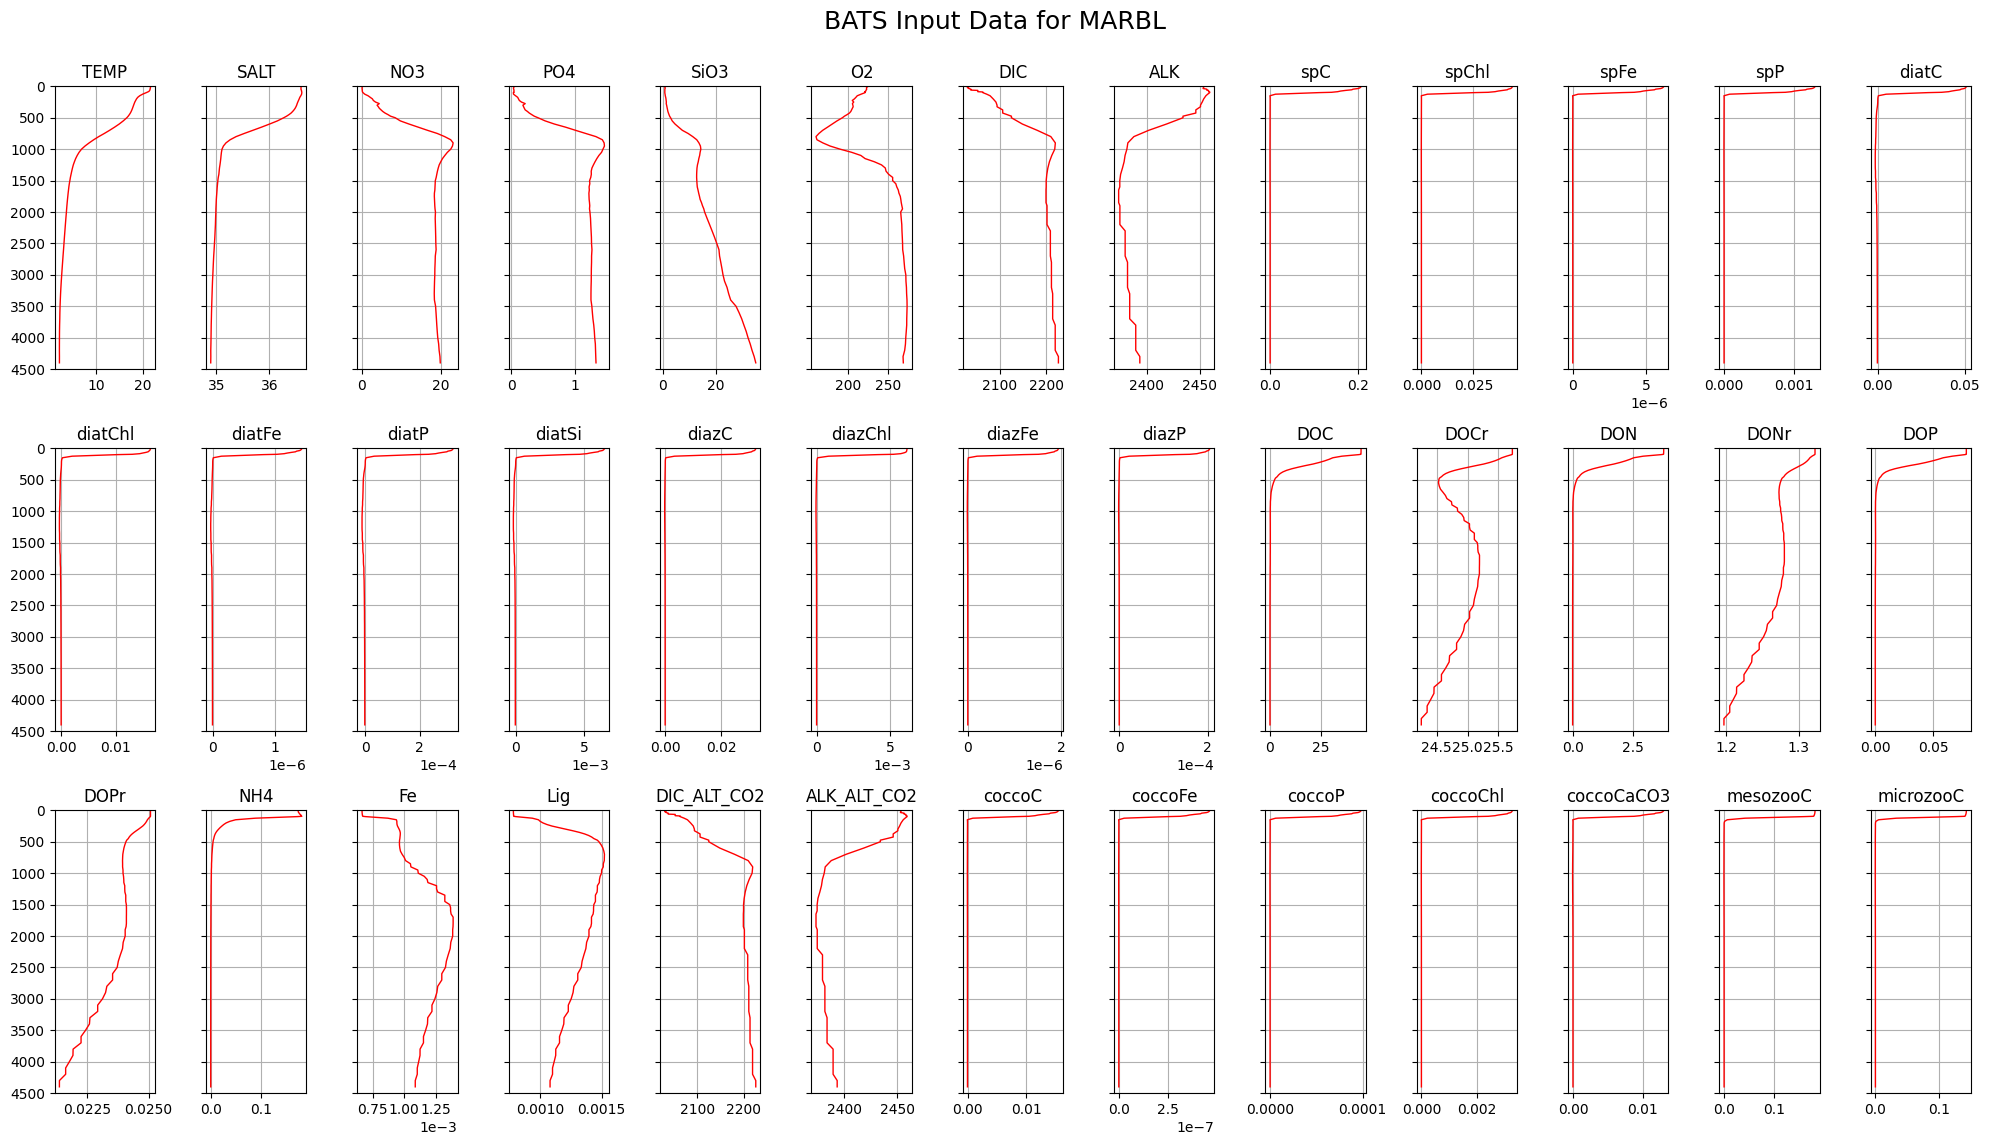

In [18]:
fig, axs = plt.subplots(nrows=3, ncols=13, figsize=(20, 12), sharey = True, dpi=100)
fig.suptitle("BATS Input Data for MARBL", fontsize=18, y=0.95)

for key, ax in zip(keys, axs.ravel()):
    ax.plot(IC_FILE_COLUMN[key][:,0,0],IC_FILE_COLUMN.DEPTH,'r',linewidth=1)

    ax.set_ylim([4500, 0])
    ax.set_title(key)
    ax.grid()
    #ax.set_xlabel(IC_FILE_COLUMN[key].units)
    ax.ticklabel_format(style='plain', axis='x')
    if key in ['spFe','diatFe','diatSi','diazChl','diatP','diazFe','diazP','Fe','coccoFe']:
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#fig.delaxes(axs[-1][-1])
#fig.delaxes(axs[-1][-2])
fig.tight_layout(rect=[0, 0, 1, 0.95])


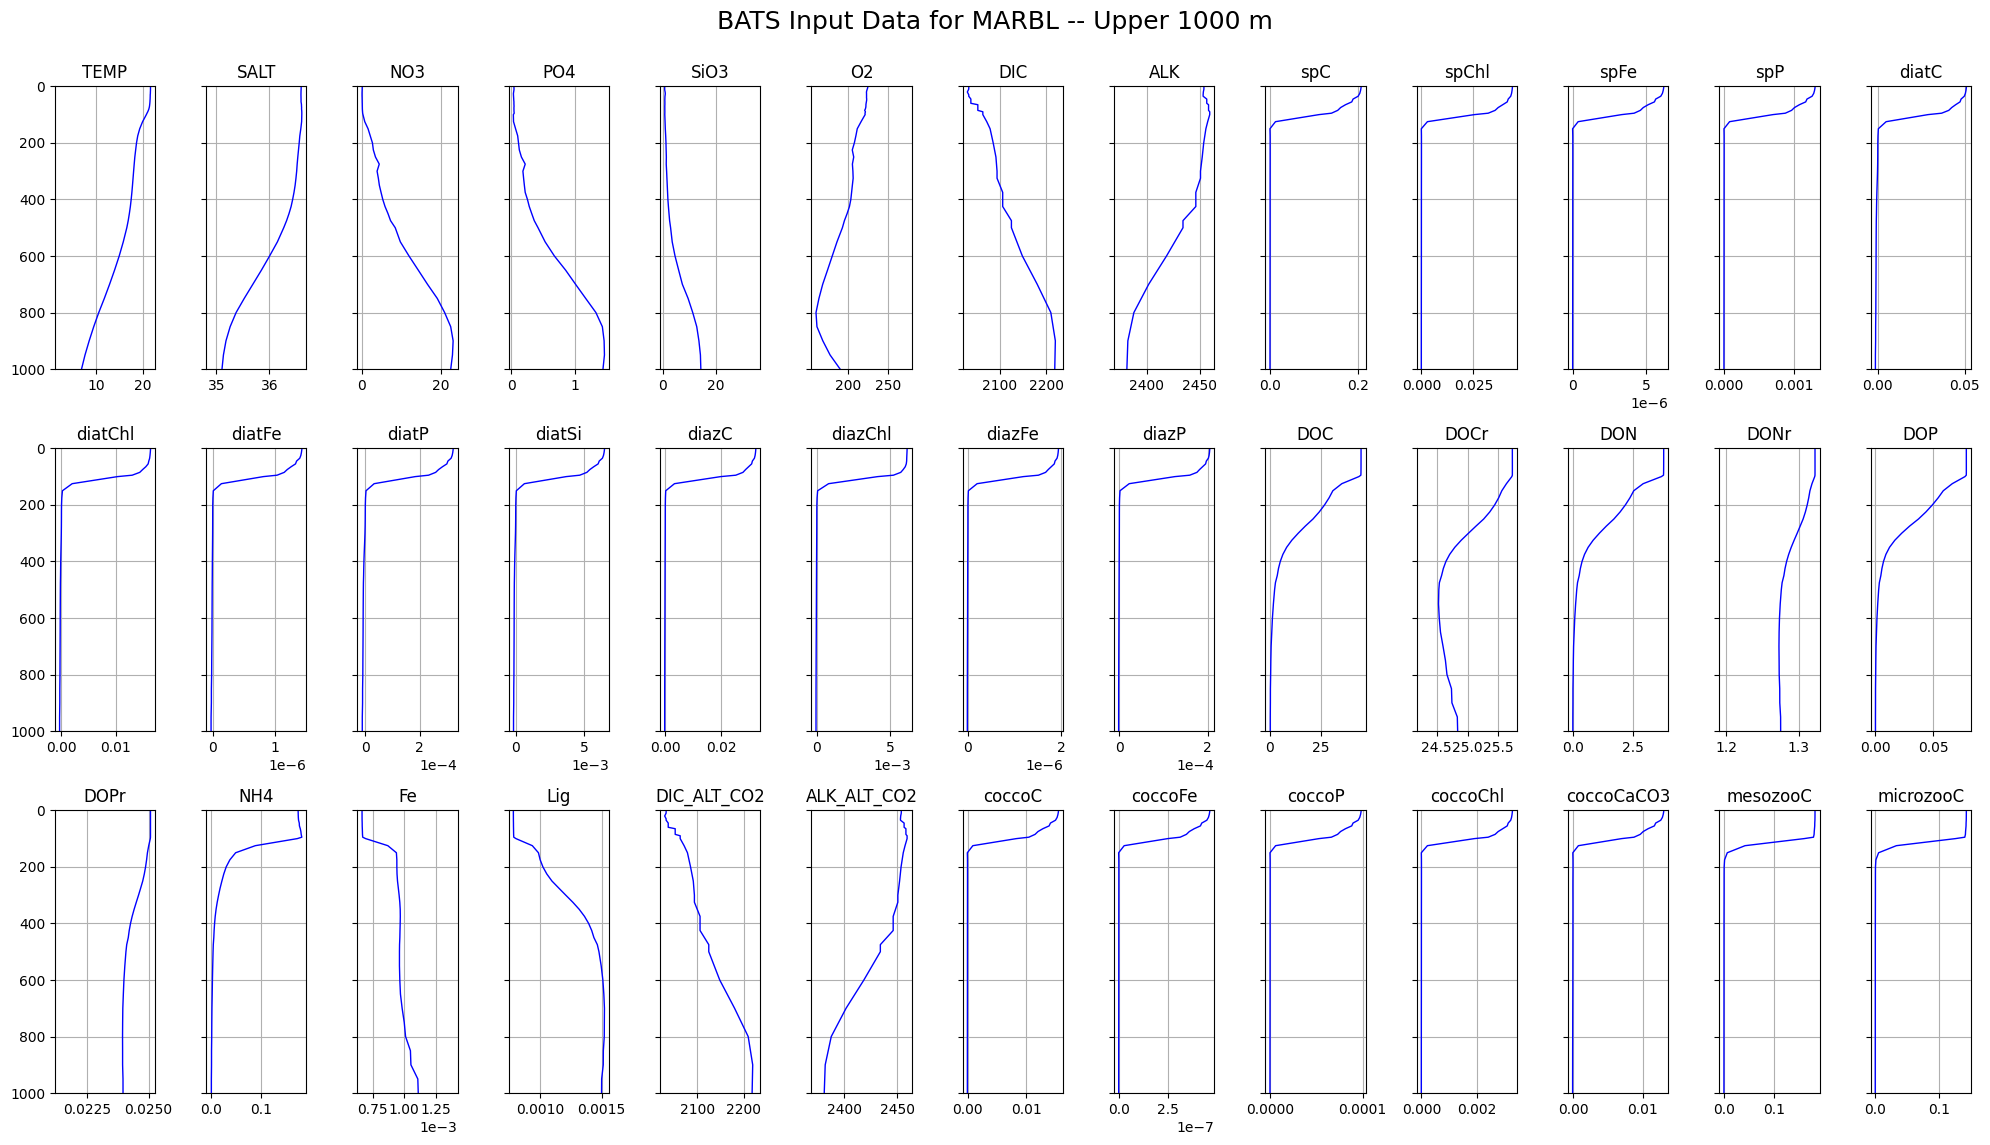

In [19]:
fig, axs = plt.subplots(nrows=3, ncols=13, figsize=(20, 12), sharey = True, dpi=100)
fig.suptitle("BATS Input Data for MARBL -- Upper 1000 m", fontsize=18, y=0.95)

for key, ax in zip(keys, axs.ravel()):
    ax.plot(IC_FILE_COLUMN[key][:,0,0],IC_FILE_COLUMN.DEPTH,'b',linewidth=1)

    ax.set_ylim([1000, 0])
    ax.set_title(key)
    ax.grid()
    #ax.set_xlabel(IC_FILE_COLUMN[key].units)
    ax.ticklabel_format(style='plain', axis='x')
    if key in ['spFe','diatFe','diatSi','diazChl','diatP','diazFe','diazP','Fe','coccoFe']:
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#fig.delaxes(axs[-1][-1])
#fig.delaxes(axs[-1][-2])
fig.tight_layout(rect=[0, 0, 1, 0.95])

In [20]:
MARBL_FORCING_FILE_COLUMN

<xarray.Dataset>
Dimensions:               (gridlat_t: 2, gridlon_t: 2, nlat: 2, nlon: 2, time: 1825)
Coordinates:
  * time                  (time) float64 0.5 1.5 2.5 ... 1.824e+03 1.824e+03
    lat                   (gridlat_t, gridlon_t) float64 ...
    lon                   (gridlat_t, gridlon_t) float64 ...
    gridlat_t             (nlat) float64 ...
    gridlon_t             (nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ATM_FINE_DUST_FLUX    (time, gridlat_t, gridlon_t) float64 ...
    ATM_COARSE_DUST_FLUX  (time, gridlat_t, gridlon_t) float64 ...
    ATM_BC_FLUX           (time, gridlat_t, gridlon_t) float64 ...
    U10_SQR               (time, gridlat_t, gridlon_t) float64 ...
    ICE_FRAC              (time, gridlat_t, gridlon_t) float64 ...
    LWDN                  (time, gridlat_t, gridlon_t) float64 ...
    SWDN                  (time, gridlat_t, gridlon_t) float64 ...
    RAIN                  (time, gridlat_t, gridlon_t) float64 ...
    EVAP                  (time, gridlat_t, gridlon_t) float64 ...
    SENS_HEAT_FLUX        (time, gridlat_t, gridlon_t) float64 ...
    TAUX                  (time, gridlat_t, gridlon_t) float64 ...
    TAUY                  (time, gridlat_t, gridlon_t) float64 ...
    SNOW                  (time, gridlat_t, gridlon_t) float64 ...

## Finally save the MARBL column input files within the BATS input directory in single_column example directory

In [22]:
#%cd /glade/u/home/eyankovsky/MOM6-examples/ocean_only/single_column/INPUT/BATS/
%cd /glade/u/home/eyankovsky/CESM/cesm2_3_alpha12b+mom6_marbl/components/mom/standalone/examples/single_column/INPUT/CESM_MOM_COLUMNS/BATS/
%rm IC_FILE_COLUMN.nc MARBL_FESEDFLUX_FILE_COLUMN.nc MARBL_FEVENTFLUX_FILE_COLUMN.nc TS_IC_FILE_COLUMN.nc MARBL_FORCING_FILE_COLUMN.nc

IC_FILE_COLUMN.to_netcdf('IC_FILE_COLUMN.nc', 'w')

TS_IC_FILE_COLUMN.to_netcdf('TS_IC_FILE_COLUMN.nc', 'w')

MARBL_FESEDFLUX_FILE_COLUMN.to_netcdf('MARBL_FESEDFLUX_FILE_COLUMN.nc','w')
MARBL_FEVENTFLUX_FILE_COLUMN.to_netcdf('MARBL_FEVENTFLUX_FILE_COLUMN.nc','w')

FLUX_FILE_COLUMN.time.attrs['modulo'] = " "
FLUX_FILE_COLUMN.to_netcdf('FLUX_FILE_COLUMN.nc','w',unlimited_dims='time')

#MARBL_FORCING_FILE_COLUMN.time.attrs['modulo'] = 1825.
MARBL_FORCING_FILE_COLUMN.to_netcdf('MARBL_FORCING_FILE_COLUMN.nc','w',unlimited_dims='time')
#
%ls



/glade/u/home/eyankovsky/CESM/cesm2_3_alpha12b+mom6_marbl/components/mom/standalone/examples/single_column/INPUT/CESM_MOM_COLUMNS/BATS
FLUX_FILE_COLUMN.nc  MARBL_FESEDFLUX_FILE_COLUMN.nc   MOM_override
forcing_monthly.nc   MARBL_FEVENTFLUX_FILE_COLUMN.nc  TS_IC_FILE_COLUMN.nc
IC_FILE_COLUMN.nc    MARBL_FORCING_FILE_COLUMN.nc     WOA_column.nc


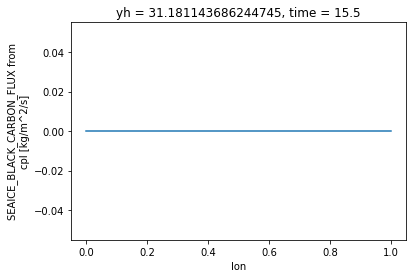

In [23]:
np.nanmax(FLUX_FILE_COLUMN.SEAICE_BLACK_CARBON_FLUX_CPL[0,0].plot())


In [31]:
testing_IC_FILE = xr.open_dataset('MARBL_FORCING_FILE_COLUMN.nc')
#testing_ICs = xr.open_dataset('ICs.nc')
testing_IC_FILE.gridlat_t

<xarray.DataArray 'gridlat_t' (nlat: 2)>
array([31.099484, 31.657515])
Coordinates:
    gridlat_t  (nlat) float64 31.1 31.66
Dimensions without coordinates: nlat
Attributes:
    units:           degree_north
    cartesian_axis:  Y

In [32]:
(1/1.5854895991882293e-08)/86400/365

2.0

## Restoring timescale

In [33]:
restoring = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v6/forcing/ecosys_restore_inv_tau_POP_gx1v6_20170125.nc')

#print(restoring.RESTORE_INV_TAU )

print('max restoring inverse timescale in years is:',(1/(np.nanmax(restoring.RESTORE_INV_TAU)))/86400/365)

max restoring inverse timescale in years is: 2.0


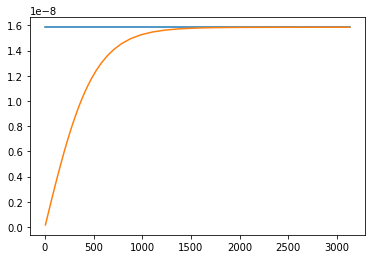

In [34]:
#plt.figure(figsize=(3, 2),dpi=150)

plt.plot(restoring.depth,restoring.RESTORE_INV_TAU[:,100,100])


plt.plot(restoring.depth,restoring.RESTORE_INV_TAU[:,100,100]*np.tanh(restoring.depth/500))


In [23]:
restoring['RESTORE_INV_TAU'] = restoring.RESTORE_INV_TAU*np.tanh(restoring.depth/500)
restoring['RESTORE_INV_TAU_MARGINAL_SEA_ONLY'] = restoring.RESTORE_INV_TAU_MARGINAL_SEA_ONLY*np.tanh(restoring.depth/500)


In [24]:
%cd /glade/u/home/eyankovsky/MOM6-examples/ocean_only/single_column/KPP_MARBL/INPUT/BATS/
%rm restoring_3D.nc

restoring.to_netcdf('restoring_3D.nc','w')
test = xr.open_dataset('restoring_3D.nc')
print(test)

/glade/u/home/eyankovsky/MOM6-examples/ocean_only/single_column/INPUT/BATS
<xarray.Dataset>
Dimensions:                            (depth: 60, nlat: 384, nlon: 320)
Coordinates:
  * depth                              (depth) float64 5.0 15.0 ... 5.375e+03
    TLONG                              (nlat, nlon) float64 ...
    TLAT                               (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT                                (nlat, nlon) int32 ...
    REGION_MASK                        (nlat, nlon) int32 ...
    RESTORE_INV_TAU                    (depth, nlat, nlon) float64 ...
    RESTORE_INV_TAU_MARGINAL_SEA_ONLY  (depth, nlat, nlon) float64 ...
Attributes:
    comment:  created by /glade/u/home/klindsay/ncl/gen_ecosys_restore_inv_ta...


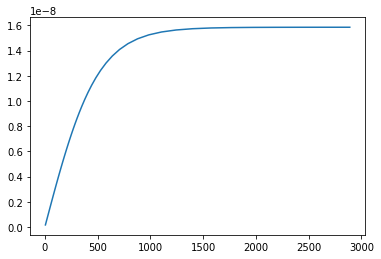

In [25]:
plt.plot(test.depth,test.RESTORE_INV_TAU[:,50,50])
